## Æther: Pipeline


In [47]:
import os
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [48]:
tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
embedding_model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to(device)

In [49]:
def loadDataset(datasets: list[tuple[str, str]]):
    """Load dataset more efficiently by reading unique files only once

    Args:
        datasets (list[tuple[str, str]]): List of tuples containing the path to the labels file and the base directory of the files.
    Returns:
        pd.DataFrame: DataFrame containing the loaded data.
    """

    columns = ["id1", "id2", "plagio", "file1", "file2"]

    df = pd.DataFrame(columns=columns)

    for labels_path, base_dir in datasets:
        labels_path = Path(labels_path)
        base_dir = Path(base_dir)

        # Validate paths
        if not labels_path.exists() or not labels_path.is_file():
            raise FileNotFoundError(f"Labels file not found: {labels_path}")
        if not base_dir.exists() or not base_dir.is_dir():
            raise FileNotFoundError(f"Base directory not found: {base_dir}")

        # Load labels
        df2 = pd.read_csv(labels_path)
        
        # ensure ids are strings
        df2["id1"] = df2["id1"].astype(str)
        df2["id2"] = df2["id2"].astype(str)

        # Ensure label is an integer
        df2["plagio"] = df2["plagio"].astype(int)


        # Get unique file IDs to load only once
        unique_ids = pd.concat([df2["id1"], df2["id2"]]).unique()

        # Load files in one pass
        files = {}
        for file_id in tqdm(unique_ids, desc="Loading files"):
            path = base_dir / f"{file_id}.java"
            if path.exists():
                try:
                    files[file_id] = path.read_text(encoding="utf-8")
                except UnicodeDecodeError:
                    files[file_id] = path.read_text(encoding="latin-1")
            else:
                raise FileNotFoundError(f"File not found: {path}")

        # Map files to dataframe
        df2["file1"] = df2["id1"].map(files)
        df2["file2"] = df2["id2"].map(files)

        # Append to main dataframe
        df = pd.concat([df, df2[columns]], ignore_index=True)

    return df

In [50]:
def embed_batch(texts, batch_size=16):
    """Custom embedding function that minimizes GPU transfers"""
    all_embeddings = []

    # Process in batches to avoid OOM issues
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch_texts = texts[i : i + batch_size]

        # Tokenize on CPU
        inputs = tokenizer(
            batch_texts, padding="longest", truncation=True, return_tensors="pt"
        )

        # Transfer to GPU only once per batch
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get embeddings (no gradient needed)
        with torch.no_grad():
            outputs = embedding_model(**inputs)

        # Use mean pooling of last hidden state as embedding
        # Taking mean across token dimension (dim=1)
        # embeddings = torch.mean(outputs.last_hidden_state, dim=1)
        
        # Use CLS token as embedding
        embeddings = outputs.pooler_output

        # Move back to CPU and convert to numpy only once per batch
        all_embeddings.append(embeddings.cpu().numpy())

    # Stack all batch results
    return np.vstack(all_embeddings) if all_embeddings else np.array([])

def embed(text):
    """Embed a single text input"""
    inputs = tokenizer(
        text, truncation=True, return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = embedding_model(**inputs)

    # Use mean pooling of last hidden state as embedding
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)[0]
    return embeddings.cpu().numpy()


In [51]:
def embed_dataset(dataset):
    """Process dataset by embedding unique files only once"""
    # Extract all unique files to embed
    all_files = []
    file_to_idx = {}

    # Create list of unique files
    unique_files = set()
    for file1, file2 in zip(dataset["file1"], dataset["file2"]):
        unique_files.add(file1)
        unique_files.add(file2)

    # Convert to list and create mapping
    all_files = list(unique_files)
    file_to_idx = {file: idx for idx, file in enumerate(all_files)}

    print(f"Embedding {len(all_files)} unique files...")

    # Embed all unique files at once
    all_embeddings = embed_batch(all_files, 128)

    # Create a dict mapping from file content to embedding
    file_to_embedding = {file: all_embeddings[idx] for file, idx in file_to_idx.items()}

    # Create a map function to add embeddings
    def add_embeddings(example):
        return {
            "embeddedFile1": file_to_embedding[example["file1"]],
            "embeddedFile2": file_to_embedding[example["file2"]],
        }

    # Use dataset.map() to add the embedded columns
    return dataset.map(add_embeddings)

In [52]:
def find_optimal_threshold(y_true, y_scores):
    """
    Find the optimal threshold for binary classification using ROC curve.
    """
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


def evaluate_model(df, threshold=None, balance_classes=True):
    if threshold is None:
        threshold = find_optimal_threshold(
            df["plagio"].values,
            df["similarity"].values,
        )
        print(f"Optimal threshold: {threshold:.2f}")

    df["predicted"] = df["similarity"].apply(lambda x: 1 if x > threshold else 0)

    report = classification_report(df["plagio"], df["predicted"])
    print(report)

    cm = confusion_matrix(df["plagio"], df["predicted"])

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Not Plagiarized", "Plagiarized"]
    )
    disp.plot(
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=plt.gca(),
    )
    plt.title("Confusion Matrix")
    plt.show()

    # Plot the distribution of the similarity scores
    plt.figure(figsize=(10, 7))
    plt.hist(
        df["similarity"], bins=50, alpha=0.7, color="blue", label="Similarity Scores"
    )
    plt.axvline(threshold, color="red", linestyle="--")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Similarity Scores")
    plt.show()

In [53]:
# Define paths
LABELS_PATH = Path("../../labels")
CONPLAG_LABEL_PATH = LABELS_PATH / "conplag_labels.csv"
IR_PLAG_LABEL_PATH = LABELS_PATH / "ir_plag_labels.csv"

BASE_DIR = Path("../../datasets")
CONPLAG_BASE_DIR = BASE_DIR / "conplag_preprocesed"
IR_PLAG_BASE_DIR = BASE_DIR / "ir_plag_preprocessed"


# Load the dataset
print("Loading dataset...")
df2 = loadDataset(
    [(CONPLAG_LABEL_PATH, CONPLAG_BASE_DIR), (IR_PLAG_LABEL_PATH, IR_PLAG_BASE_DIR)]
)

dataset = Dataset.from_pandas(df2)

# Process dataset (embed files)
print("Processing dataset...")
embedded_dataset = embed_dataset(dataset)

Loading dataset...


Loading files: 100%|██████████| 460/460 [00:00<00:00, 35279.12it/s]


Processing dataset...
Embedding 1393 unique files...


Map: 100%|██████████| 1371/1371 [00:00<00:00, 10075.43 examples/s]


In [54]:
# Split dataset into train, validation, and test sets
# 80% train, 10% validation, 10% test
print("Splitting dataset...")

df2 = embedded_dataset.to_pandas()

X = np.array([np.subtract(row["embeddedFile1"], row["embeddedFile2"]) 
              for _, row in df2.iterrows()], dtype=np.float32)

Y = df2["plagio"].values.astype(np.float32)


# Split the combined dataset
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Train, validation, and test datasets prepared.")
print(f"Length of train set: {len(Y_train)}, Length of validation set: {len(Y_val)}, Length of test set: {len(Y_test)}")
print(f"Input dimension: {X_train.shape[1]}")


Splitting dataset...
Train, validation, and test datasets prepared.
Length of train set: 1096, Length of validation set: 138, Length of test set: 137
Input dimension: 768


In [116]:
input_dim = X_train.shape[1]

print(f"Input dimension: {input_dim}")

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.6),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.6),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid(),
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.BCELoss()

Input dimension: 768


In [ ]:
num_epochs = 100
batch_size = 32

In [122]:


# Training loop
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = torch.tensor(X_train[i : i + batch_size]).to(device)
        batch_Y = torch.tensor(Y_train[i : i + batch_size]).to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_X = torch.tensor(X_val).to(device)
        val_Y = torch.tensor(Y_val).to(device).unsqueeze(1)
        val_outputs = model(val_X)
        val_loss = criterion(val_outputs, val_Y)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = (val_predictions == val_Y).float().mean()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}")



Epoch [1/100], Loss: 0.2972, Val Loss: 1.5209, Val Accuracy: 0.8623
Epoch [2/100], Loss: 0.1217, Val Loss: 1.5852, Val Accuracy: 0.8551
Epoch [3/100], Loss: 0.4964, Val Loss: 1.6128, Val Accuracy: 0.8551
Epoch [4/100], Loss: 0.0385, Val Loss: 1.6316, Val Accuracy: 0.8551
Epoch [5/100], Loss: 0.0507, Val Loss: 1.6369, Val Accuracy: 0.8623
Epoch [6/100], Loss: 0.0432, Val Loss: 1.6209, Val Accuracy: 0.8696
Epoch [7/100], Loss: 0.0976, Val Loss: 1.6258, Val Accuracy: 0.8623
Epoch [8/100], Loss: 0.0952, Val Loss: 1.6025, Val Accuracy: 0.8623
Epoch [9/100], Loss: 0.1073, Val Loss: 1.6119, Val Accuracy: 0.8551
Epoch [10/100], Loss: 0.1311, Val Loss: 1.6173, Val Accuracy: 0.8551
Epoch [11/100], Loss: 0.0679, Val Loss: 1.6553, Val Accuracy: 0.8551
Epoch [12/100], Loss: 0.1161, Val Loss: 1.6867, Val Accuracy: 0.8623
Epoch [13/100], Loss: 0.2334, Val Loss: 1.6742, Val Accuracy: 0.8551
Epoch [14/100], Loss: 0.0468, Val Loss: 1.6265, Val Accuracy: 0.8551
Epoch [15/100], Loss: 0.0656, Val Loss: 1.6

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89        73
         1.0       0.96      0.77      0.85        64

    accuracy                           0.88       137
   macro avg       0.89      0.87      0.87       137
weighted avg       0.89      0.88      0.87       137



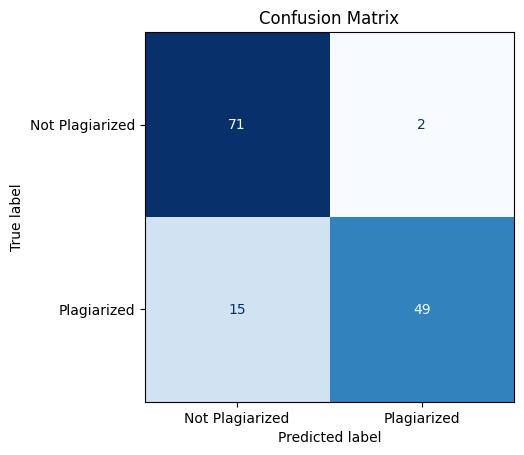

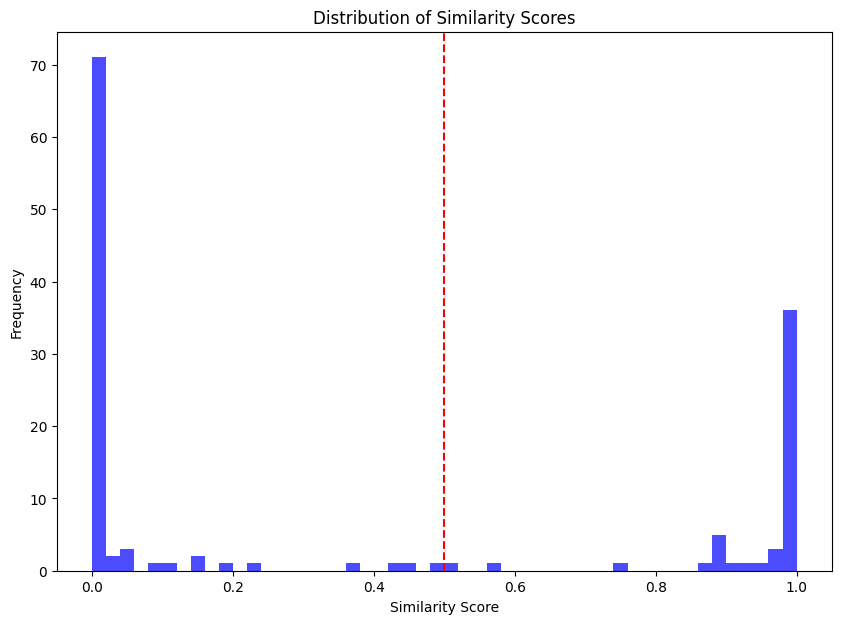

In [123]:
# test the model
model.eval()
with torch.no_grad():
    test_X = torch.tensor(X_test).to(device)
    test_Y = torch.tensor(Y_test).to(device).unsqueeze(1)
    outputs = model(test_X)
    test_Y = test_Y.cpu().numpy().flatten()
    outputs = outputs.cpu().numpy().flatten()
    df_test = pd.DataFrame({"plagio": test_Y, "similarity": outputs})

evaluate_model(df_test, threshold=0.5)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       621
         1.0       1.00      0.99      0.99       475

    accuracy                           0.99      1096
   macro avg       0.99      0.99      0.99      1096
weighted avg       0.99      0.99      0.99      1096



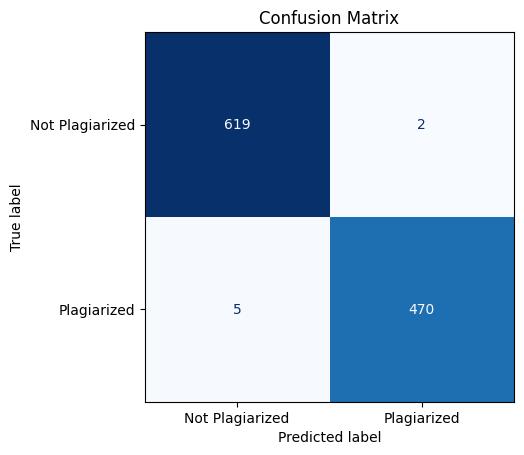

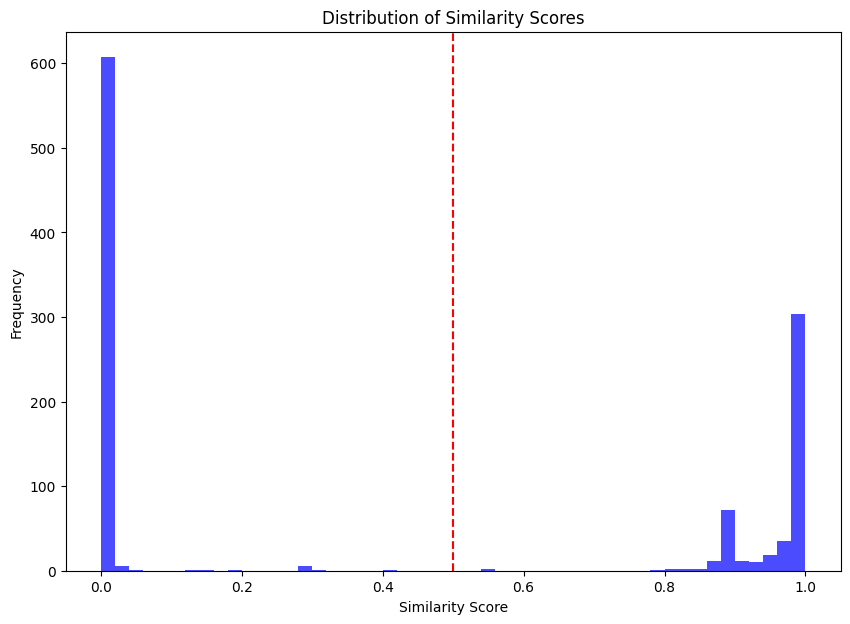

In [124]:
model.eval()
with torch.no_grad():
    train_X = torch.tensor(X_train).to(device)
    train_Y = torch.tensor(Y_train).to(device).unsqueeze(1)
    outputs = model(train_X)
    train_Y = train_Y.cpu().numpy().flatten()
    outputs = outputs.cpu().numpy().flatten()
    df_train = pd.DataFrame({"plagio": train_Y, "similarity": outputs})

evaluate_model(df_train, threshold=0.5)